In [1]:
import os

# for when on NCC to be able to import local packages
os.chdir(os.path.expanduser("~/l3_project"))

In [2]:
import time
import platform
import random

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models
import torchvision.transforms.v2 as transforms
import wandb
import safetensors.torch as st

import dataset_processing.ucmerced
import helpers

print(f'Using PyTorch {torch.__version__} on {platform.system()}')

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Found {torch.cuda.get_device_name()} to use as a cuda device.')
elif platform.system() == 'Darwin':
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using {device} as torch device.')

if platform.system() != 'Linux':
    torch.set_num_threads(1)  # significantly speeds up data loading processes with less loading overhead
    # see https://discuss.pytorch.org/t/pytorch-v2-high-cpu-consumption/205990 and https://discuss.pytorch.org/t/cpu-usage-far-too-high-and-training-inefficient/57228
    print('Set number of threads to 1 as using a non-Linux machine.')

Using PyTorch 2.5.1 on Linux
Found NVIDIA A100 80GB PCIe MIG 1g.10gb to use as a cuda device.
Using cuda as torch device.


In [3]:
class ChoiceRotationTransform:
    """Rotate by one of the given angles."""

    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        img = x["image"]
        img = transforms.functional.rotate(img, angle)
        x["image"] = img
        return x

In [4]:
training_transforms = transforms.Compose([
    transforms.Resize((256, 256), antialias=False),
    transforms.RandomApply([  # transpose
        ChoiceRotationTransform([90]),
        transforms.RandomHorizontalFlip(p=1)
    ], p=0.5),
    ChoiceRotationTransform([0, 90, 180, 270]),
    transforms.RandomRotation(7),  # rotates further in range -7 to +7

    transforms.CenterCrop((227, 227)),
    transforms.ToDtype(torch.float32, scale=True),
])

testing_transforms = transforms.Compose([
    transforms.Resize((256, 256), antialias=False),

    transforms.CenterCrop((227, 227)),
    transforms.ToDtype(torch.float32, scale=True),
])

train_dataset = dataset_processing.ucmerced.get_dataset("train", training_transforms, download=True)
validation_dataset = dataset_processing.ucmerced.get_dataset("val", testing_transforms, download=True)
test_dataset = dataset_processing.ucmerced.get_dataset("test", testing_transforms, download=True)

In [5]:
print(
    f"There are {len(train_dataset)} training samples, {len(validation_dataset)} validation samples, and {len(test_dataset)} test samples.")
print("Image dimensions and eg label:", train_dataset[0]["image"].size(), train_dataset[0]["label"])

There are 1260 training samples, 420 validation samples, and 420 test samples.
Image dimensions and eg label: torch.Size([3, 227, 227]) tensor(0)


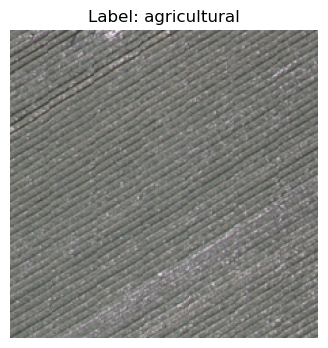

In [6]:
train_dataset.plot(train_dataset[0])
plt.show()

## Model setup

In [7]:
class DeepCNN(nn.Module):
    """
    Implements DCNN architecture inspired by
    Scott, G. J., England, M. R., Starms, W. A., Marcum, R. A., & Davis, C. H. (2017).
    Training Deep Convolutional Neural Networks for Land–Cover Classification of High-Resolution Imagery.
    IEEE Geoscience and Remote Sensing Letters, 14(4), 549-553.
    https://doi.org/10.1109/LGRS.2017.2657778
    """

    def __init__(self, num_classes):
        super().__init__()
        self.resnet50_base = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
        self.resnet50_base.fc = nn.Sequential(  # modify final layer to be more similar to one used in paper
            nn.Dropout(p=0.5),
            nn.Linear(self.resnet50_base.fc.in_features, 4096)
        )
        self.classifying_layer = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.resnet50_base(x)
        x = self.classifying_layer(nn.ReLU(x))
        return x

    def freeze_resnet_layers(self, up_to: int):
        """
        Freeze layers (requires_grad = False) up to a certain depth starting from input layer
        :param up_to: Depth exclusive to freeze layers up to starting from input layer
        :return:
        """
        for depth_from_input, layer in enumerate(self.resnet50_base.children()):
            if depth_from_input < up_to:
                for param in layer.parameters():
                    param.requires_grad = False

    def unfreeze_layers(self):
        """
        Unfreeze all layers in the model.
        :return:
        """
        for param in self.parameters():
            param.requires_grad = True

    def extra_repr(self):
        """
        Add additional detail on number of frozen layers.
        :return:
        """
        num_frozen = 0
        frozen_layers = []
        for layer in self.resnet50_base.children():
            for param in layer.parameters():
                if not param.requires_grad:
                    num_frozen += 1
                    frozen_layers.append(layer)
                    break

        return f"> {num_frozen} layers frozen: {', '.join([layer.__class__.__name__ for layer in frozen_layers])} <"

In [8]:
deepCNN = DeepCNN(num_classes=len(train_dataset.classes)).to(device)
deepCNN.freeze_resnet_layers(len(list(deepCNN.resnet50_base.children())) - 1)  # training just fc and classifying layer
print(deepCNN)

DeepCNN(
  > 6 layers frozen: Conv2d, BatchNorm2d, Sequential, Sequential, Sequential, Sequential <
  (resnet50_base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_ru

In [9]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, num_workers=2, shuffle=True)
validation_iterator = iter(cycle(validation_dataloader))

In [11]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
decay = 1e-6
momentum = 0.9
parameters_to_optimise = filter(lambda p: p.requires_grad, deepCNN.parameters())
optimiser = torch.optim.SGD(parameters_to_optimise, lr=learning_rate, weight_decay=decay, momentum=momentum,
                            nesterov=True)

In [12]:
def train_step(model_to_train, input_img, targets: torch.Tensor, train_criterion, model_optimiser, train_loss_arr,
               train_acc_arr, val_data_iterator, step_num, epoch, device, dataloader_len):
    preds: torch.Tensor = model_to_train(input_img)

    loss = train_criterion(preds, targets)
    train_loss_arr = np.append(train_loss_arr, loss.item())

    acc = (preds.argmax(dim=1) == targets).float().mean().item()
    train_acc_arr = np.append(train_acc_arr, acc)

    model_optimiser.zero_grad()
    loss.backward()
    model_optimiser.step()

    if step_num % 200 == 0:
        log_dict = helpers.ml.during_training_validation_step(model_to_train, train_criterion, val_data_iterator,
                                                              train_loss_arr,
                                                              train_acc_arr, step_num, epoch, device, dataloader_len)
        wandb.log(log_dict)

In [21]:
num_epochs = 100

wandb.init(
    project="l3_sat_project",
    name="Fine-tuning ResNet50 - UCMerced",
    resume="auto",
    notes="Fine-tuning ResNet50 on UC Merced dataset.",
    config={
        "transforms": repr(training_transforms),
        "model_architecture": repr(deepCNN),
        "criterion": criterion.__class__.__name__,
        "optimiser_info": {
            "name": optimiser.__class__.__name__,
            "learning_rate": learning_rate,
            "decay": decay,
            "momentum": momentum
        },
        "dataset": "UCMerced",
        "epochs": num_epochs,
        "start_time": time.asctime()
    }
)

training_loss_arr = np.zeros(0)
training_acc_arr = np.zeros(0)

for epoch in range(num_epochs):
    print(f"Epoch {epoch:03}")
    for i, data in enumerate(train_dataloader):
        deepCNN.train()
        images = data["image"].to(device)
        labels: torch.Tensor = data["label"].to(device)
        train_step(deepCNN, images, labels, criterion, optimiser, training_loss_arr, training_acc_arr,
                   validation_iterator, i, epoch, device, len(train_dataloader))

    if epoch != 0 and epoch % 20 == 0:
        st.save_model(deepCNN, f"checkpoints/resnet50_ucm_epoch_{epoch:03}.safetensors",
                      metadata={"epoch": str(epoch)})
        print(f"Model saved at epoch {epoch:03}.")

KeyboardInterrupt: 